# Share Analysis

The following Jupyter Notebook performs some light data aggregation on data pulled from https://simfin.com/data/bulk

In [147]:
import simfin as sf
import pandas as pd
import numpy as np
# Set your SimFin+ API-key for downloading data.
sf.set_api_key('MK6G4JQw6QnhL8Vf6292q81zGQSd0iPg')

# Set the local directory where data-files are stored.
# The directory will be created if it does not already exist.
sf.set_data_dir('../simfin_data/')

# Download the data from the SimFin server and load into a Pandas DataFrame.
df_shares = sf.load_shareprices(variant='daily', market='us')
df_industries = sf.load_industries()
df_companies = sf.load_companies(market='us')

# Print the first rows of the data.
print(df_shares.head())
print(df_industries.head())
print(df_companies.head())

Dataset "us-shareprices-daily" on disk (0 days old).
- Loading from disk ... Done!
Dataset "industries" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-companies" on disk (0 days old).
- Loading from disk ... Done!
                   SimFinId   Open    Low   High  Close  Adj. Close  Dividend  \
Ticker Date                                                                     
A      2015-11-30     45846  41.97  41.61  42.05  41.82       39.69       NaN   
       2015-12-01     45846  42.16  41.04  42.31  41.06       38.97       NaN   
       2015-12-02     45846  41.07  40.37  41.46  40.42       38.36       NaN   
       2015-12-03     45846  40.64  39.95  40.74  40.15       38.11       NaN   
       2015-12-04     45846  40.23  40.13  41.20  41.10       39.01       NaN   

                    Volume  Shares Outstanding  
Ticker Date                                     
A      2015-11-30  3207714         331403231.0  
      

Left Join industries and companies data set onto the share data by SimFinId and IndustryId respectively

In [149]:
# Left Join Company and Industry data onto Shares
df_merge_temp = pd.merge(df_shares,df_companies,on='SimFinId',how='left').set_index(df_shares.index)
df_merged = pd.merge(df_merge_temp,df_industries,on='IndustryId',how='left').set_index(df_shares.index)
print(df_merged.head())

                   SimFinId   Open    Low   High  Close  Adj. Close  Dividend  \
Ticker Date                                                                     
A      2015-11-30     45846  41.97  41.61  42.05  41.82       39.69       NaN   
       2015-12-01     45846  42.16  41.04  42.31  41.06       38.97       NaN   
       2015-12-02     45846  41.07  40.37  41.46  40.42       38.36       NaN   
       2015-12-03     45846  40.64  39.95  40.74  40.15       38.11       NaN   
       2015-12-04     45846  40.23  40.13  41.20  41.10       39.01       NaN   

                    Volume  Shares Outstanding              Company Name  \
Ticker Date                                                                
A      2015-11-30  3207714         331403231.0  AGILENT TECHNOLOGIES INC   
       2015-12-01  7989220         332170890.0  AGILENT TECHNOLOGIES INC   
       2015-12-02  4713210         332170890.0  AGILENT TECHNOLOGIES INC   
       2015-12-03  3314529         332170890.0  AGIL

When calculating stock-returns you should always use the Adj. Close share-price because it takes both stock-splits and dividends into account. This is especially important over longer periods because the dividend reinvestment can be a significant part of the returns.

But when calculating valuation ratios such as P/E or P/Sales you should use the Close share-price instead, which is only adjusted for stock-splits. If you were to use the Adj. Close share-price then you would distort the valuation ratios.

For example, the stock with ticker MSFT has the following share-price data:

In [150]:
# get a list of all company tickers to loop through
Tickers = np.unique(df_shares.index.get_level_values(0))

for ticker in Tickers:
    print("Ticker:", ticker)
    # select data by ticker and relevant years before grouping by year
    # 2015 hast too few data points to aggregate representative values
    print(df_shares.loc[ticker]['2016':'2020'].groupby(pd.Grouper(freq="Y")).agg(
        # Average stock daily closing prices per year and company ticker
        mean_close=pd.NamedAgg(column='Close', aggfunc='mean'),
        # Median stock daily closing prices per year and company ticker
        median_close=pd.NamedAgg(column='Close', aggfunc='median'),
        min_close=pd.NamedAgg(column='Close', aggfunc='min'),
        # Maximum and minimum daily closing prices per year and company ticker
        max_close=pd.NamedAgg(column='Close', aggfunc='max'),

        min_adj_close=pd.NamedAgg(column='Adj. Close', aggfunc='min'),
        max_adj_close=pd.NamedAgg(column='Adj. Close', aggfunc='max'),
        mean_adj_close=pd.NamedAgg(column='Adj. Close', aggfunc='mean'),
        median_adj_close=pd.NamedAgg(column='Adj. Close', aggfunc='median'),
    ))

Ticker: A
            min_close  max_close  mean_close  median_close  min_adj_close  \
Date                                                                        
2016-12-31      34.80      48.44   43.369960        44.870          33.12   
2017-12-31      46.49      70.59   59.329681        59.800          44.73   
2018-12-31      61.13      74.82   67.169363        67.000          59.49   
2019-12-31      63.27      85.45   75.211825        75.785          61.99   
2020-12-31      63.37     116.90   90.181948        89.260          62.62   

            max_adj_close  mean_adj_close  median_adj_close  
Date                                                         
2016-12-31          46.35       41.455317            42.865  
2017-12-31          68.37       57.295538            57.800  
2018-12-31          72.98       65.430438            65.310  
2019-12-31          84.29       73.929921            74.505  
2020-12-31         116.24       89.406234            88.440  
Ticker: AA
     

## • Average stock daily closing prices per year, as average of a whole industry ('Aerospace & Defense')

            mean_close
Date                  
2015-12-31   61.805366
2016-12-31   63.844294
2017-12-31   79.087897
2018-12-31   94.624440
2019-12-31   99.036808
2020-12-31   84.887810


<AxesSubplot:title={'center':'BA'}, xlabel='Date'>

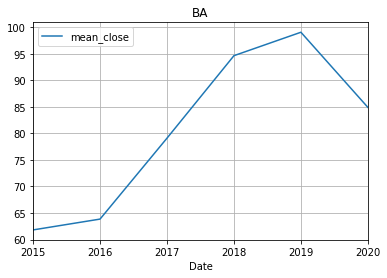

In [204]:
# df_shares.groupby([pd.Grouper(freq="Y",level='Date'),]).agg(mean_close=pd.NamedAgg(column='Close', aggfunc='mean'))
mean_closing_by_year_aero = df_merged[df_merged['Industry'] == 'Aerospace & Defense'].groupby([pd.Grouper(freq="Y",level='Date'),]).agg(mean_close=pd.NamedAgg(column='Close', aggfunc='mean'))
print(mean_closing_by_year_aero)
mean_closing_by_year_aero[['mean_close']].plot(title='Aerospace & Defense', grid=True)

## • Showing the prices for a dedicated company, please take Boeing for this (Ticker: BA)

In [200]:
ba_close_values = df_shares.loc['BA'].groupby(pd.Grouper(freq="Y")).agg(
        # Average stock daily closing prices per year and company ticker
        mean_close=pd.NamedAgg(column='Close', aggfunc='mean'),
        # Median stock daily closing prices per year and company ticker
        median_close=pd.NamedAgg(column='Close', aggfunc='median'),
        min_close=pd.NamedAgg(column='Close', aggfunc='min'),
        # Maximum and minimum daily closing prices per year and company ticker
        max_close=pd.NamedAgg(column='Close', aggfunc='max'),

        min_adj_close=pd.NamedAgg(column='Adj. Close', aggfunc='min'),
        max_adj_close=pd.NamedAgg(column='Adj. Close', aggfunc='max'),
        mean_adj_close=pd.NamedAgg(column='Adj. Close', aggfunc='mean'),
        median_adj_close=pd.NamedAgg(column='Adj. Close', aggfunc='median'),)
print(ba_close_values)



            mean_close  median_close  min_close  max_close  min_adj_close  \
Date                                                                        
2015-12-31  145.193913       145.450     139.58     148.50         125.11   
2016-12-31  133.111587       131.950     108.44     157.81          98.11   
2017-12-31  215.253904       201.480     156.97     297.90         145.46   
2018-12-31  344.694143       344.720     294.16     392.30         282.67   
2019-12-31  365.027659       362.925     310.90     440.62         302.12   
2020-12-31  194.475108       171.200      95.01     347.45          95.01   

            max_adj_close  mean_adj_close  median_adj_close  
Date                                                         
2015-12-31         133.10      130.140000           130.370  
2016-12-31         146.24      121.551984           120.305  
2017-12-31         283.84      202.986215           189.790  
2018-12-31         379.47      331.895259           332.440  
2019-12-31 

## Showing the average prices segmented by industries

In [201]:

closing_by_industry = df_merged.groupby('Industry').agg(mean_close=pd.NamedAgg(column='Close', aggfunc='mean'))
print(closing_by_industry)

                                         mean_close
Industry                                           
Advertising & Marketing Services          33.485399
Aerospace & Defense                       83.494796
Agriculture                               32.350691
Airlines                                  56.504331
Alternative Energy Sources & Other        22.523341
...                                             ...
Travel & Leisure                          82.200325
Truck Manufacturing                       33.303481
Utilities - Independent Power Producers   28.218687
Utilities - Regulated                     56.787970
Waste Management                          35.202119

[74 rows x 1 columns]


<AxesSubplot:title={'center':'BA'}, xlabel='Date'>

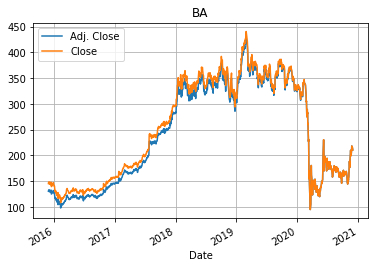

In [194]:
df_shares.loc['BA'][['Adj. Close','Close']].plot(title='BA', grid=True)

<AxesSubplot:title={'center':'BA'}, xlabel='Date'>

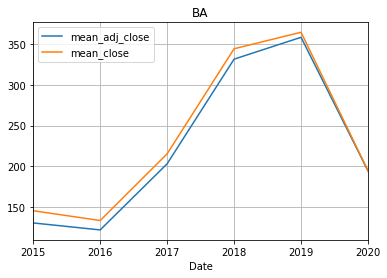

In [198]:
ba_close_values[['mean_adj_close','mean_close']].plot(title='BA', grid=True)
